In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from vogn import VOGN
from models import SimpleConvNet
from datasets import Dataset
from utils import train_model
from utils import inference
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch.nn.functional as F
import time
sns.set()
from torch.utils.data.dataloader import DataLoader

Note : attention aux colums de file_A et file, columns en plus etc...

In [2]:

# Test wether GPUs are available
use_cuda =  torch.cuda.is_available()
print("Using Cuda: %s" % use_cuda)

# Set Random Seed
torch.manual_seed(42)

Using Cuda: True


In [3]:
class csvDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        file = pd.read_csv(csv_file)
        
        
        a=['Pass/Fail']
        
        self.label = np.array(file[a].values=='Fail')*(-1.)+1
        
        a = []
        
        for i in list(file_A.columns):
            if i != 'Pass/Fail':
                a.append(i)
                
        data = np.array(file[a].values)       
        for i in range(16):
            data[:,i]=(data[:,i] - data[:,i].mean())/(data[:,i].std())
                
        self.data = data
         
        #self.train_set = TensorDataset()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        data = self.data[idx]
        label = self.label[idx]
        sample = { 'data': data,'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        data, label  = sample['data'],sample['label']
        
        
        return {'data': torch.from_numpy(data).float(),
                'label': torch.from_numpy(label).float()}

In [4]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(type(self), self).__init__()
        
        self.layer1 = nn.Linear(16, 64)
        self.layer2 = nn.Linear(64, 256)
        self.layer3 = nn.Linear(256, 256)
        self.layer4 = nn.Linear(256, 1)
        
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        out = self.layer4(x)
        return out

In [8]:
file_dataset = csvDataset(csv_file='circuit-design/opAmp_280nm_GF55_Mod_30P.csv',transform= ToTensor())

In [9]:
file = pd.read_csv('circuit-design/opAmp_280nm_GF55_Mod_30P.csv')
        
        
a=['Pass/Fail']
        
label = np.array(file[a].values=='Fail')*(-1.)+1
        
a = []
        
for i in list(file.columns):
    if i != 'Pass/Fail':
        a.append(i)
                
data = np.array(file[a].values)   

for i in range(16):
    data[:,i]=(data[:,i] - data[:,i].mean())/(data[:,i].std())
data

array([[-1.        , -1.22474487, -1.        , ...,  1.41675504,
         0.        , 30.93171296],
       [-1.        , -1.22474487, -1.        , ...,  1.04780248,
         0.        ,         nan],
       [-1.        , -1.22474487, -1.        , ...,  1.1953835 ,
         0.        ,         nan],
       ...,
       [ 1.        ,  1.22474487,  1.        , ..., -0.77166073,
         0.        ,         nan],
       [ 1.        ,  1.22474487,  1.        , ..., -0.74952358,
         0.        ,         nan],
       [ 1.        ,  1.22474487,  1.        , ..., -0.78905421,
         0.        ,         nan]])

In [10]:
file_A = pd.read_csv('circuit-design/opAmp_280nm_GF55.csv')

In [11]:
file.columns

Index(['VDD', 'Ib', 'Lg1', 'Lg2', 'Lrf', 'Wcf', 'Wg1', 'Wg2', 'temperature',
       'Pass/Fail', 'ACM_G', 'SR', 'CMRR', 'NOISE', 'PSRR', 'PhaseMargin_PM',
       'BandWidth', 'Pass/Fail.1', 'Percentage'],
      dtype='object')

In [12]:
file_A.columns

Index(['VDD', 'Ib', 'Lg1', 'Lg2', 'Lrf', 'Wcf', 'Wg1', 'Wg2', 'temperature',
       'Pass/Fail', 'ACM_G', 'SR', 'CMRR', 'NOISE', 'PSRR', 'PhaseMargin_PM',
       'BandWidth'],
      dtype='object')

In [13]:
#dataset_loader = torch.utils.data.DataLoader(file_dataset,batch_size=43, shuffle=True)
dataset_loader = torch.utils.data.DataLoader(file_dataset,
                                             batch_size=1, shuffle=True)

In [14]:
def train_model_bb(model, dataloaders, criterion, optimizer, num_epochs=25):
    """
    Performs Training and Validation on test set on the given model using the specified optimizer
    :param model: (nn.Module) Model to be trained
    :param dataloaders: (list) train and test dataloaders
    :param criterion: Loss Function
    :param optimizer: Optimizer to be used for training
    :param num_epochs: Number of epochs to train the model
    :return: trained model, test and train metric history
    """
    train_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []
    test_loss_history = []
    trainloader, testloader = dataloaders

    for epoch in range(num_epochs):
        model.train(True)
        print('Epoch[%d]:' % epoch)
        running_train_loss = 0.
        a=0
        for i in (trainloader):
            a+=1
            inputs = i['data']
            labels = i['label']
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            if isinstance(optimizer, VOGN):
                def closure():
                    optimizer.zero_grad()
                    logits = model.forward(inputs)
                    loss = criterion(logits, labels)
                    return loss
            else:
                def closure():
                    optimizer.zero_grad()
                    logits = model.forward(inputs)
                    loss = criterion(logits, labels)
                    loss.backward()
                    return loss
            loss = optimizer.step(closure)
            running_train_loss += loss.detach().item()

            # Print Training Progress
            if a%500 == 1:
                train_accuracy = accuracy_bb(model, trainloader)
                print('Iteration[%d]: Train Loss: %f   Train Accuracy: %f ' % (a+1, running_train_loss/a, train_accuracy))

        train_accuracy, train_loss = accuracy_bb(model, trainloader, criterion)
        train_accuracy_history.append(train_accuracy)
        train_loss_history.append(train_loss)
        print('## Epoch[%d], Train Loss: %f   &   Train Accuracy: %f' % (epoch, train_loss, train_accuracy))
    return model, train_loss_history, train_accuracy_history

In [15]:
def accuracy_bb(model, dataloader, criterion=None):
    """ Computes the model's classification accuracy on the train dataset
        Computes classification accuracy and loss(optional) on the test dataset
        The model should return logits
    """
    model.eval()
    with torch.no_grad():
        correct = 0.
        running_loss = 0.
        for i in (dataloader):
            inputs = i['data']
            labels = i['label']
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item()
            pred = (outputs>0).float()
            correct += (pred.view(-1,1) == labels).sum().item()
        accuracy = correct / len(dataloader.dataset)
        if criterion is not None:
            running_loss = running_loss / len(dataloader)
            return accuracy, loss
    return accuracy

In [16]:
model = SimpleConvNet()
if use_cuda:
    model = model.float().cuda()
criterion = F.binary_cross_entropy_with_logits
optimizer = VOGN(model, train_set_size=6912, prec_init=1e2, num_samples=4)
optimizer_bb = optim.Adam(model.parameters())

In [59]:
model, train_loss, train_accuracy = train_model_bb(model, [dataset_loader, dataset_loader], criterion,
optimizer_bb, num_epochs=10)

Epoch[0]:
Iteration[2]: Train Loss: 0.698586   Train Accuracy: 0.680122 
Iteration[502]: Train Loss: 0.428873   Train Accuracy: 0.857350 
Iteration[1002]: Train Loss: 0.382852   Train Accuracy: 0.888744 
Iteration[1502]: Train Loss: 0.347987   Train Accuracy: 0.893519 
Iteration[2002]: Train Loss: 0.316407   Train Accuracy: 0.918547 
Iteration[2502]: Train Loss: 0.287932   Train Accuracy: 0.919994 
Iteration[3002]: Train Loss: 0.271743   Train Accuracy: 0.928241 
Iteration[3502]: Train Loss: 0.264420   Train Accuracy: 0.937066 
Iteration[4002]: Train Loss: 0.249510   Train Accuracy: 0.917824 
Iteration[4502]: Train Loss: 0.240025   Train Accuracy: 0.953559 
Iteration[5002]: Train Loss: 0.232073   Train Accuracy: 0.956453 
Iteration[5502]: Train Loss: 0.223266   Train Accuracy: 0.949797 
Iteration[6002]: Train Loss: 0.214820   Train Accuracy: 0.955729 
Iteration[6502]: Train Loss: 0.208537   Train Accuracy: 0.947627 
## Epoch[0], Train Loss: 0.166809   &   Train Accuracy: 0.927083
Epoch

Iteration[2002]: Train Loss: 0.028485   Train Accuracy: 0.982928 
Iteration[2502]: Train Loss: 0.030961   Train Accuracy: 0.984809 
Iteration[3002]: Train Loss: 0.030550   Train Accuracy: 0.959925 
Iteration[3502]: Train Loss: 0.033177   Train Accuracy: 0.988281 
Iteration[4002]: Train Loss: 0.037121   Train Accuracy: 0.988715 
Iteration[4502]: Train Loss: 0.036873   Train Accuracy: 0.981047 
Iteration[5002]: Train Loss: 0.038819   Train Accuracy: 0.990307 
Iteration[5502]: Train Loss: 0.039487   Train Accuracy: 0.989294 
Iteration[6002]: Train Loss: 0.037800   Train Accuracy: 0.984086 
Iteration[6502]: Train Loss: 0.037309   Train Accuracy: 0.992188 
## Epoch[8], Train Loss: 0.029607   &   Train Accuracy: 0.987703
Epoch[9]:
Iteration[2]: Train Loss: 0.000000   Train Accuracy: 0.987703 
Iteration[502]: Train Loss: 0.037933   Train Accuracy: 0.982784 
Iteration[1002]: Train Loss: 0.034388   Train Accuracy: 0.988281 
Iteration[1502]: Train Loss: 0.028080   Train Accuracy: 0.985677 
Itera

In [19]:
model = SimpleConvNet()
if use_cuda:
    model = model.float().cuda()
criterion = F.binary_cross_entropy_with_logits
optimizer = VOGN(model, train_set_size=6912, prec_init=1e2, num_samples=10)
optimizer_bb = optim.Adam(model.parameters())

In [22]:
start = time.time()

model, train_loss, train_accuracy = train_model_bb(model, [dataset_loader, dataset_loader], criterion,
optimizer, num_epochs=3)

end = time.time()
print(end - start)

Epoch[0]:
Iteration[2]: Train Loss: 0.467743   Train Accuracy: 0.690683 
Iteration[502]: Train Loss: 0.508369   Train Accuracy: 0.746094 
Iteration[1002]: Train Loss: 0.502671   Train Accuracy: 0.503038 
Iteration[1502]: Train Loss: 0.543362   Train Accuracy: 0.311777 
Iteration[2002]: Train Loss: 0.597592   Train Accuracy: 0.549624 
Iteration[2502]: Train Loss: 0.654485   Train Accuracy: 0.646701 
Iteration[3002]: Train Loss: 1.314352   Train Accuracy: 0.774450 
Iteration[3502]: Train Loss: 1.239271   Train Accuracy: 0.603154 
Iteration[4002]: Train Loss: 1.288505   Train Accuracy: 0.745660 
Iteration[4502]: Train Loss: 1.281556   Train Accuracy: 0.671007 
Iteration[5002]: Train Loss: 1.338921   Train Accuracy: 0.631800 
Iteration[5502]: Train Loss: 1.318080   Train Accuracy: 0.690683 
Iteration[6002]: Train Loss: 1.261539   Train Accuracy: 0.690683 
Iteration[6502]: Train Loss: 1.243715   Train Accuracy: 0.789207 
## Epoch[0], Train Loss: 1.201649   &   Train Accuracy: 0.728588
Epoch

Attention ne pas reentrainer !!!

_________________________________________

In [24]:
inference_loader = torch.utils.data.DataLoader(file_dataset,
                                             batch_size=6912, shuffle=False)

In [25]:
def inference_bb(model, data, optimizer,mc_samples):
    a=0
    for i in (inference_loader):
        a+=1
        if a == 1:
            inputs = i['data']
            labels = i['label']
            
    if use_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
                
    return optimizer.get_mc_predictions(model.forward,inputs,mc_samples=mc_samples)[0]>0,labels

In [26]:
a,b=inference_bb(model, inference_loader,optimizer,1)

In [27]:
import time

In [28]:
predict = torch.zeros(1000,6912).cuda()
labz = torch.zeros(1000,6912).cuda()
start = time.time()
for i in range(1000):
    predictions,lbl = inference_bb(model, inference_loader,optimizer,1)
    predict[i] = predictions.view(6912)
    labz[i] = lbl.view(6912)
end = time.time()
print(end - start)

97.7634346485138


In [29]:
hist=torch.zeros(6912)
histl=torch.zeros(6912)
for i in range(6912):
    hist[i] = torch.mean(predict[:,i])
    histl[i] = torch.mean(labz[:,i])

In [30]:
np.sum((hist>0.5)*1.==histl)

RuntimeError: Expected object of scalar type Byte but got scalar type Float for argument #2 'other'

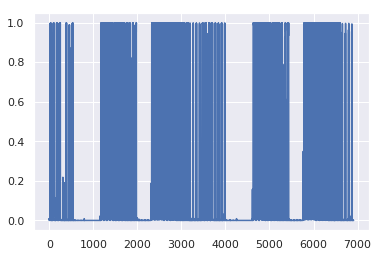

In [106]:
plt.plot(hist.numpy())

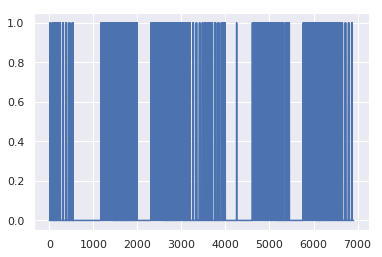

In [107]:
plt.plot(histl.numpy())

In [108]:
a=0
for i in (inference_loader):
        a+=1
        inputs = i['data']
        labels = i['label']
        print(a,inputs.shape,np.mean(labels.numpy()))

1 torch.Size([6912, 16]) 0.30931714


In [109]:
inference_loader.dataset.data.shape

(6912, 16)

____________________

In [110]:
def crit(vect,thresh):
    a = vect>thresh
    b = vect < (1-thresh)

    return a*b*1.

In [111]:
np.sum(crit(hist.numpy(),0.20))

198.0

In [116]:
def better_pred(labz,thresh,vect):

    critz = crit(vect,thresh)
    preds = vect>0.5
    
    correct_better = 0.
    correct = 0.
    correct+= np.sum((labz-preds)==0)
    correct_better = np.sum(((labz-preds)==0)*(critz==0))
    
    return correct/6912,correct_better/(6912-np.sum(critz))
    

In [117]:
better_pred(histl.numpy(),0.1,hist.numpy())

(0.9376446759259259, 0.954800546033672)

In [118]:
x = np.linspace(0,0.5,601)
rez = [better_pred(histl.numpy(),y,hist.numpy()) for y in x]

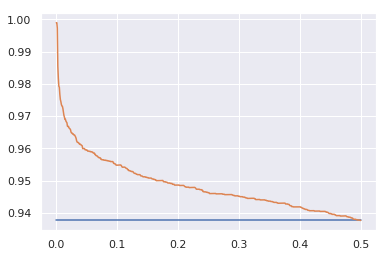

In [119]:
plt.plot(x,rez)